In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import euclidean

# For results repeatability
np.random.seed(0)

# Dataset preprocessing

## Dataset 1

In [2]:
dataset = pd.read_csv("data/adult.data", header=None)

In [3]:
dataset.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]

In [4]:
dataset = dataset[(dataset!=" ?").all(axis=1)].reset_index(drop=True)
df_strings = dataset.select_dtypes(['object'])
dataset[df_strings.columns] = df_strings.apply(lambda x: x.str.strip())

In [5]:
clean_dataset = pd.DataFrame(dataset["age"])
for col in dataset.columns[1:-1]:
    if(dataset[col].dtype =='O'):
        clean_dataset = clean_dataset.join(pd.get_dummies(dataset[col], prefix=col))
    else:
        clean_dataset = clean_dataset.join(dataset[col])
labels = (dataset["salary"]==">50K")*1
dataset = clean_dataset

## Dataset 2

# Error measure

In [6]:
def error(predicted_labels, real_labels, loss="euclidean"):
    """
    Input: numpy array containing respectively the labels an algorithm predicted, and the real labels corresponding
    to the data. Type of loss we want to use.
    
    Output: float, the computed loss.
    """
    if loss == "euclidean": return euclidean(predicted_labels, real_labels)
    elif loss == "manhattan": return sum(abs(predicted_labels - real_labels))
    
    

# Knn

We use scikit-learn's knn function to design a knn classifier.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
def knn(training_features, training_labels, to_predict_features,
        n_neighbors=5, weights = "uniform", algorithm="auto", p=2):
    
    """
    Input: Training data, features for which we want to predict the labels, number of neighbors k for knn algo,
    features weights system (uniform or distance), algorithm usewd to find closer k neighbors, p is the value
    used in the computation of the minkowski distance that is used here, p=1 gives a manhattan distance, p=2 a
    euclidian distance.
    
    Output: Numpy array containing the labels predicted by KNN for the given 'to_predict_features'
    """
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, p=p)
    neigh.fit(training_features, training_labels)
    
    return neigh.predict(to_predict_features)

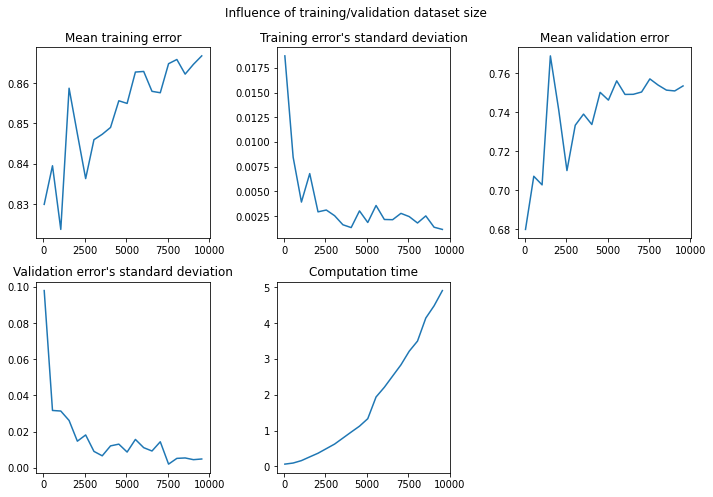

In [47]:
data_size_influence(knn, dataset, labels, 50, 10000, 500, loss_="manhattan", folds = 5, algo_kwargs={"n_neighbors":3}, show_time=True, visualize=True)
    

# Decision tree

# Cross validation

In [11]:
def cross_validation(algo, dataset_, labels_, loss_="manhattan", folds = 5, algo_kwargs={}):
    """
    Input : Predictor function that works by supplying training set and labels and test set and return predicted labels
            dataset  and corresponding labels
            folds
            algo_kwargs : a dict with additional params for the algo : ex. {'n_neighbors':5}
    Output : Precision mean and variance
    """
    dataset_size = dataset_.shape[0]
    group_ids = np.tile(np.arange(folds),int(dataset_size/folds)+1)[:dataset_size]
    np.random.shuffle(group_ids)
    training_precisions = []
    validation_precisions = []
    for N in range(folds):
        training_set = dataset_[group_ids != N]
        training_labels = labels_[group_ids != N]
        test_set = dataset_[group_ids == N]
        test_labels = labels_[group_ids == N]
        # Training error
        training_predicted_labels = algo(training_set, training_labels, training_set, **algo_kwargs)
        training_precisions += [(len(training_labels) - error(training_predicted_labels, training_labels, loss = loss_))/len(training_labels)]
    
        
        # Validation error
        validation_predicted_labels = algo(training_set, training_labels, test_set, **algo_kwargs)
        validation_precisions += [(len(test_labels) - error(validation_predicted_labels, test_labels, loss = loss_))/len(test_labels)]
    
    
    return (np.mean(training_precisions), np.std(training_precisions), np.mean(validation_precisions), np.std(validation_precisions))

In [12]:
cross_validation(knn, dataset[:1000], labels[:1000], folds = 10, algo_kwargs={'n_neighbors':3})

(0.8475555555555555, 0.004812535072823947, 0.718, 0.04190465367951392)

# Influence of dataset's size

Now we study the influence of the size of the training / validation dataset on the training / validation errors.

In [48]:
def data_size_influence(algo, dataset_, labels_, N_start, N_end, N_step, loss_="manhattan", folds = 5, algo_kwargs={}, show_time=False, visualize=True):
    
    nrows = data.shape[0]
    Ns = []
    mean_trainings = []
    std_trainings = []
    mean_validations = []
    std_validations = []
    
    if show_time: times = []
    
    for N in range(N_start, N_end, N_step):
        Ns.append(N)
        indices = list(np.random.choice(nrows, N))
        d = dataset.iloc[indices]
        l = labels.iloc[indices]
        
        if show_time: t = time.time()
        mean_training, std_training, mean_validation, std_validation = cross_validation(knn, d, l, folds = folds, algo_kwargs=algo_kwargs)
        if show_time: times.append(time.time() - t)
        
        mean_trainings.append(mean_training)
        std_trainings.append(std_training)
        mean_validations.append(mean_validation)
        std_validations.append(std_validation)
    
    if visualize:
        fig = plt.figure(figsize=(10,7))
        fig.suptitle("Influence of training/validation dataset size")
        ax1 = fig.add_subplot(231)
        ax1.title.set_text("Mean training precision")
        ax1.plot(Ns, mean_trainings)

        ax2 = fig.add_subplot(232)
        ax2.title.set_text("Training precision's standard deviation")
        ax2.plot(Ns, std_trainings)

        ax3 = fig.add_subplot(233)
        ax3.title.set_text("Mean validation precision")
        ax3.plot(Ns, mean_validations)

        ax4 = fig.add_subplot(234)
        ax4.title.set_text("Validation precision's standard deviation")
        ax4.plot(Ns, std_validations)

        if show_time:
            ax5 = fig.add_subplot(235)
            ax5.title.set_text("Computation time")
            ax5.plot(Ns, times)
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=3, 
                        top=3, 
                        wspace=1, 
                        hspace=1)

        fig.tight_layout()
        plt.show()
    
    if show_time: return (Ns, mean_trainings, std_trainings, mean_validations, std_validations, times)
    else: return (Ns, mean_trainings, std_trainings, mean_validations, std_validations)

